In [1]:
# 安装Python库rpy2
!pip install rpy2

# 安装R包INLA及其依赖包
!R -e "install.packages(c('sp', 'fmesher'), repos=c('http://cran.r-project.org'))"
!R -e "install.packages('INLA', repos='https://inla.r-inla-download.org/R/stable')"


R version 4.4.0 (2024-04-24) -- "Puppy Cup"
Copyright (C) 2024 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> install.packages(c('sp', 'fmesher'), repos=c('http://cran.r-project.org'))
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’, ‘sf’, ‘Rcpp’

trying URL 'http://cran.r-project.org/src/contrib/proxy_0.4-27.tar

In [2]:
pip install --upgrade rpy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rpy2: filename=rpy2-3.5.16-cp310-cp310-linux_x86_64.whl size=329863 sha256=3be833a1df870de9e30fde1db703901a89953767bd1d0aaf8becbf5d23b99cab
  Stored in directory: /root/.cache/pip/wheels/86/9b/1a/c09b2935ab01605117b270e2abb744a10f5b213c6f9b7213ce
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2


In [3]:
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 使用 localconverter 来确保正确的转换上下文
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df)

# 尝试加载INLA库，捕获任何错误
try:
    ro.r('library(INLA)')
except RRuntimeError as e:
    print(f"Failed to load INLA library in R: {e}")

# 现在r_df是R的data.frame，可以在R代码中使用
print("R data.frame is ready to use in R.")



 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation



R data.frame is ready to use in R.


In [4]:
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 将 Pandas DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df)

# 尝试加载 INLA 库，捕获任何错误
try:
    ro.r('library(INLA)')
except RRuntimeError as e:
    print(f"Failed to load INLA library in R: {e}")

def run_inla_model(formula, data, model_name):
    # 确保转换上下文在函数调用中正确设置
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        try:
            # 运行 INLA 模型
            result = ro.r(f"""
                result <- inla(formula = {formula}, data = r_df, family = 'gaussian',
                               control.predictor = list(compute = TRUE))
                summary(result)
            """)
            # 提取和打印模型摘要
            print(result)
            # 提取边缘对数似然值
            mlik = result['mlik'][0]
            print(f"Model: {model_name}")
            print(f"Marginal log likelihood: {mlik}")
            print()
        except RRuntimeError as e:
            print(f"Error running INLA model for {model_name}: {e}")

# 定义基础模型公式
base_model_formula = "SentimentScore ~ HeatCount"

# 运行基础模型
print("Running Base Model")
run_inla_model(base_model_formula, r_df, "Base Model")

Running Base Model
o{'call':  [1] "inla.core(formula = formula, family = family, contrasts = contrasts, "                 
 [2] "    data = data, quantiles = quantiles, E = E, offset = offset, "                      
 [3] "    scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, "            
 [4] "    lp.scale = lp.scale, link.covariates = link.covariates, verbose = verbose, "       
 [5] "    lincomb = lincomb, selection = selection, control.compute = control.compute, "     
 [6] "    control.predictor = control.predictor, control.family = control.family, "          
 [7] "    control.inla = control.inla, control.fixed = control.fixed, "                      
 [8] "    control.mode = control.mode, control.expert = control.expert, "                    
 [9] "    control.hazard = control.hazard, control.lincomb = control.lincomb, "              
[10] "    control.update = control.update, control.lp.scale = control.lp.scale, "            
[11] "    control.pardiso = con

In [5]:
import geopandas as gpd
import pandas as pd

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 打印列名
print("Columns in GeoDataFrame (shapefile):")
print(gdf.columns)

print("\nColumns in DataFrame (CSV file):")
print(df.columns)

Columns in GeoDataFrame (shapefile):
Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')

Columns in DataFrame (CSV file):
Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')


In [6]:
# 安装 spdep 包（在 R 环境中运行）
ro.r('install.packages("spdep")')

(as ‘lib’ is unspecified)



















	‘/tmp/RtmpnAv1LY/downloaded_packages’



In [7]:
import geopandas as gpd
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# 删除 geometry 列以避免转换错误
gdf = gdf.drop(columns='geometry')

# 合并数据集
merged_df = gdf.merge(df, left_on='GEOID', right_on='GEOID')

# 将合并后的 DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(merged_df)

# 尝试加载 INLA 库，捕获任何错误
try:
    ro.r('library(INLA)')
    ro.r('library(spdep)')
except RRuntimeError as e:
    print(f"Failed to load INLA or spdep library in R: {e}")


package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`





In [8]:
import geopandas as gpd
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# 删除 geometry 列以避免转换错误
gdf = gdf.drop(columns='geometry')

# 合并数据集
merged_df = gdf.merge(df, left_on='GEOID', right_on='GEOID')

# 将合并后的 DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(merged_df)

# 尝试加载 INLA 和 spdep 库，捕获任何错误
try:
    ro.r('library(INLA)')
    ro.r('library(spdep)')
except RRuntimeError as e:
    print(f"Failed to load INLA or spdep library in R: {e}")

def run_inla_spatial_model(formula, data, spatial_data, model_name):
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        ro.r.assign("spatial_data", spatial_data)
        try:
            # 生成空间权重矩阵
            ro.r('nb <- poly2nb(spatial_data)')
            ro.r('lw <- nb2listw(nb, style="W")')

            # 运行 INLA 模型并直接打印结果
            result = ro.r(f"""
                result <- inla(formula = {formula}, data = r_df, family = 'gaussian',
                               control.compute = list(config = TRUE),
                               control.predictor = list(A = inla.spde.make.A(lw)))
                summary(result)
            """)
            print(f"Model: {model_name} completed successfully.")
            return result
        except RRuntimeError as e:
            print(f"Error running INLA spatial model for {model_name}: {e}")
            return None

def run_all_models(models, data):
    results = {}
    for name, formula in models.items():
        print(f"Running {name}")
        result = run_inla_spatial_model(formula, data, gdf, name)
        if result:
            results[name] = result
    return results

# 更新模型公式以包含空间效应
spatial_model_formula = """
SentimentScore ~ as.factor(CountyName) + as.factor(Year) + as.factor(Month) +
                  Week + Weekend + Holiday + VulnerabilityIndex +
                  f(spatial_effect, model = "besag", graph = lw)
"""

# 定义包含空间效应的模型
models = {
    "Spatial Model + Heatwave": spatial_model_formula + " + HeatCount",
    "Spatial Model + Air Pollution": spatial_model_formula + " + AirPolllution_Interpolate",
    "Spatial Model + Precipitation": spatial_model_formula + " + Precipitation",
    "Spatial Model + All Environmental Factors": spatial_model_formula + " + HeatCount + AirPolllution_Interpolate + Precipitation"
}

# 运行所有包含空间效应的模型
model_results = run_all_models(models, r_df)

Running Spatial Model + Heatwave


/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ALAND". Fall back to string conversion. The error is: integer 6016818946 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "AWATER". Fall back to string conversion. The error is: integer 2908633230 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '



Error running INLA spatial model for Spatial Model + Heatwave: Error in poly2nb(spatial_data) : Not a polygon object

Running Spatial Model + Air Pollution


Error running INLA spatial model for Spatial Model + Air Pollution: Error in poly2nb(spatial_data) : Not a polygon object

Running Spatial Model + Precipitation


Error running INLA spatial model for Spatial Model + Precipitation: Error in poly2nb(spatial_data) : Not a polygon object

Running Spatial Model + All Environmental Factors


Error running INLA spatial model for Spatial Model + All Environmental Factors: Error in poly2nb(spatial_data) : Not a polygon object



这里说明是有问题，我们需要检查数据集
-----------------------------------------

这个错误提示表明传递给 `poly2nb` 函数的数据不是一个有效的多边形对象（polygon object）。这可能是因为在合并数据时，几何信息 (`geometry` 列) 被删除，导致 `spatial_data` 不再包含多边形对象。

In [9]:
import geopandas as gpd
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# 合并数据集
merged_df = gdf.merge(df, left_on='GEOID', right_on='GEOID')

# 将合并后的 DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(merged_df)

# 尝试加载 INLA 和 spdep 库，捕获任何错误
try:
    ro.r('library(INLA)')
    ro.r('library(spdep)')
except RRuntimeError as e:
    print(f"Failed to load INLA or spdep library in R: {e}")

def run_inla_spatial_model(formula, data, spatial_data, model_name):
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        ro.r.assign("spatial_data", spatial_data)
        try:
            # 生成空间权重矩阵
            ro.r('nb <- poly2nb(spatial_data$geometry)')
            ro.r('lw <- nb2listw(nb, style="W")')

            # 运行 INLA 模型并直接打印结果
            result = ro.r(f"""
                result <- inla(formula = {formula}, data = r_df, family = 'gaussian',
                               control.compute = list(config = TRUE),
                               control.predictor = list(A = inla.spde.make.A(lw)))
                summary(result)
            """)
            print(f"Model: {model_name} completed successfully.")
            return result
        except RRuntimeError as e:
            print(f"Error running INLA spatial model for {model_name}: {e}")
            return None

def run_all_models(models, data):
    results = {}
    for name, formula in models.items():
        print(f"Running {name}")
        result = run_inla_spatial_model(formula, data, gdf, name)
        if result:
            results[name] = result
    return results

# 更新模型公式以包含空间效应
spatial_model_formula = """
SentimentScore ~ as.factor(CountyName) + as.factor(Year) + as.factor(Month) +
                  Week + Weekend + Holiday + VulnerabilityIndex +
                  f(spatial_effect, model = "besag", graph = lw)
"""

# 定义包含空间效应的模型
models = {
    "Spatial Model + Heatwave": spatial_model_formula + " + HeatCount",
    "Spatial Model + Air Pollution": spatial_model_formula + " + AirPolllution_Interpolate",
    "Spatial Model + Precipitation": spatial_model_formula + " + Precipitation",
    "Spatial Model + All Environmental Factors": spatial_model_formula + " + HeatCount + AirPolllution_Interpolate + Precipitation"
}

# 运行所有包含空间效应的模型
model_results = run_all_models(models, r_df)

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "geometry". Fall back to string conversion. The error is: 'GeometryDtype' object has no attribute 'isnative'
  warnings.warn('Error while trying to convert '


Running Spatial Model + Heatwave


/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ALAND". Fall back to string conversion. The error is: integer 6016818946 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "AWATER". Fall back to string conversion. The error is: integer 2908633230 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '



Error running INLA spatial model for Spatial Model + Heatwave: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + Air Pollution


Error running INLA spatial model for Spatial Model + Air Pollution: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + Precipitation


Error running INLA spatial model for Spatial Model + Precipitation: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + All Environmental Factors


Error running INLA spatial model for Spatial Model + All Environmental Factors: Error in poly2nb(spatial_data$geometry) : Not a polygon object



In [10]:
import geopandas as gpd

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 打印 GeoDataFrame 的前几行以查看其结构和内容
print(gdf.head())
# 打印列名和数据类型
print(gdf.columns)
print(gdf.dtypes)

  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477645345  10690204  +41.9158651   
1  G4020  None   None     None        A   680976231  61568965  +46.2946377   
2  G4020  None   None     None        A  6016818946  29090018  +34.3592729   
3  G4020   339  30700     None        A  2169272970  22847034  +40.7835474   
4  G4020  None   None     None        A  1489645185   1718484  +40.1764918   

       INTPTLON  geoid_j                    

  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477645345  10690204  +41.9158651   
1  G4020  None   None     None        A   680976231  61568965  +46.2946377   
2  G4020  None   None     None        A  6016818946  29090018  +34.3592729   
3  G4020   339  30700     None        A  2169272970  22847034  +40.7835474   
4  G4020  None   None     None        A  1489645185   1718484  +40.1764918   

       INTPTLON  geoid_j                    

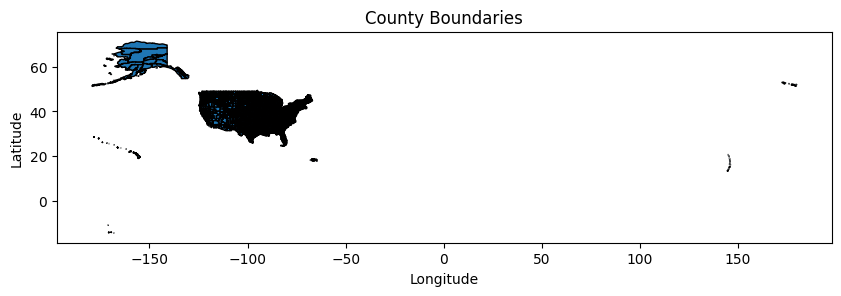

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 打印 GeoDataFrame 的前几行以查看其结构和内容
print(gdf.head())

# 可视化整个县的边界
gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title('County Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# 打印 GeoDataFrame 和 DataFrame 的前几行以查看其结构和内容
print("GeoDataFrame columns:", gdf.columns)
print("DataFrame columns:", df.columns)

# 检查两个数据集的 GEOID 列是否有重叠
common_geoids = set(gdf['GEOID']).intersection(set(df['GEOID']))
print(f"Number of common GEOIDs: {len(common_geoids)}")

# 合并数据集，保留共有的县
merged_df = gdf[gdf['GEOID'].isin(common_geoids)].merge(df, on='GEOID')

# 检查合并后的 GeoDataFrame
print("Merged GeoDataFrame:", merged_df.head())

# 确保合并后的 GeoDataFrame 不为空
if not merged_df.empty:
    # 可视化两个数据集重合的县
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_df.plot(ax=ax, edgecolor='black')
    plt.title('Overlapping Counties')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No overlapping counties found.")

GeoDataFrame columns: Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')
DataFrame columns: Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')
Number of common GEOIDs: 0
Merged GeoDataFrame: Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, COUNTYNS, NAME, NAMELSAD, LSAD, CLASSFP, MTFCC, CSAFP, CBSAFP, METDIVFP, FUNCSTAT, ALAND, AWATER, INTPTLAT, INTPTLON, geoid_j, geometry, GEOID, CountyName, STATEcode, STATEname, Date, H

In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)
df['GEOID'] = df['GEOID'].astype(str)

# 打印 GeoDataFrame 和 DataFrame 的前几行以查看其结构和内容
print("GeoDataFrame columns:", gdf.columns)
print("DataFrame columns:", df.columns)

# 打印两个数据集中GEOID列的前几行以进行检查
print("\nGeoDataFrame GEOID values:")
print(gdf['GEOID'].head())

print("\nDataFrame GEOID values:")
print(df['GEOID'].head())

# 检查两个数据集的 GEOID 列是否有重叠
common_geoids = set(gdf['GEOID']).intersection(set(df['GEOID']))
print(f"Number of common GEOIDs: {len(common_geoids)}")

# 如果没有重叠的 GEOID，打印不匹配的示例
if len(common_geoids) == 0:
    print("\nNo common GEOIDs found.")
    print("\nExample GEOID values from GeoDataFrame:")
    print(gdf['GEOID'].unique()[:10])
    print("\nExample GEOID values from DataFrame:")
    print(df['GEOID'].unique()[:10])

# 合并数据集，保留共有的县
merged_df = gdf[gdf['GEOID'].isin(common_geoids)].merge(df, on='GEOID')

# 检查合并后的 GeoDataFrame
print("Merged GeoDataFrame:", merged_df.head())

# 确保合并后的 GeoDataFrame 不为空
if not merged_df.empty:
    # 可视化两个数据集重合的县
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_df.plot(ax=ax, edgecolor='black')
    plt.title('Overlapping Counties')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No overlapping counties found.")

GeoDataFrame columns: Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')
DataFrame columns: Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')

GeoDataFrame GEOID values:
0    31039
1    53069
2    35011
3    31109
4    31129
Name: GEOID, dtype: object

DataFrame GEOID values:
0    6001
1    6001
2    6001
3    6001
4    6001
Name: GEOID, dtype: object
Number of common GEOIDs: 0

No common GEOIDs found.

Example GEOID va

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 加利福尼亚州的州代码是 06
state_code = '06'

# 确保数据具有共同的列进行合并（例如 'GEOID'）
# 将 'GEOID' 列转换为字符串类型，并添加州代码前缀
gdf['GEOID'] = gdf['GEOID'].apply(lambda x: state_code + x.zfill(3))
df['GEOID'] = df['GEOID'].apply(lambda x: state_code + str(x).zfill(3))

# 打印 GeoDataFrame 和 DataFrame 的前几行以查看其结构和内容
print("GeoDataFrame columns:", gdf.columns)
print("DataFrame columns:", df.columns)

# 打印两个数据集中GEOID列的前几行以进行检查
print("\nGeoDataFrame GEOID values:")
print(gdf['GEOID'].head())

print("\nDataFrame GEOID values:")
print(df['GEOID'].head())

# 检查两个数据集的 GEOID 列是否有重叠
common_geoids = set(gdf['GEOID']).intersection(set(df['GEOID']))
print(f"Number of common GEOIDs: {len(common_geoids)}")

# 如果没有重叠的 GEOID，打印不匹配的示例
if len(common_geoids) == 0:
    print("\nNo common GEOIDs found.")
    print("\nExample GEOID values from GeoDataFrame:")
    print(gdf['GEOID'].unique()[:10])
    print("\nExample GEOID values from DataFrame:")
    print(df['GEOID'].unique()[:10])

# 合并数据集，保留共有的县
merged_df = gdf[gdf['GEOID'].isin(common_geoids)].merge(df, on='GEOID')

# 检查合并后的 GeoDataFrame
print("Merged GeoDataFrame:", merged_df.head())

# 确保合并后的 GeoDataFrame 不为空
if not merged_df.empty:
    # 可视化两个数据集重合的县
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_df.plot(ax=ax, edgecolor='black')
    plt.title('Overlapping Counties')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No overlapping counties found.")

GeoDataFrame columns: Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')
DataFrame columns: Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')

GeoDataFrame GEOID values:
0    0631039
1    0653069
2    0635011
3    0631109
4    0631129
Name: GEOID, dtype: object

DataFrame GEOID values:
0    066001
1    066001
2    066001
3    066001
4    066001
Name: GEOID, dtype: object
Number of common GEOIDs: 0

No common GEOIDs foun

In [15]:
import geopandas as gpd
import pandas as pd

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 打印 GeoDataFrame 的前几行以查看其结构和内容
print("GeoDataFrame columns:", gdf.columns)
print("DataFrame columns:", df.columns)

# 打印两个数据集中GEOID列的前几行以进行检查
print("\nGeoDataFrame GEOID values:")
print(gdf['GEOID'].head())

print("\nDataFrame GEOID values:")
print(df['GEOID'].head())

# 筛选加利福尼亚州的县（STATEFP 为 '06'）
ca_gdf = gdf[gdf['STATEFP'] == '06']

# 打印筛选出的加利福尼亚州县的 GEOID 值
print("\nCalifornia counties GEOID values from GeoDataFrame:")
print(ca_gdf['GEOID'].unique())

# 打印 DataFrame 中的 GEOID 值
print("\nCalifornia counties GEOID values from DataFrame:")
print(df['GEOID'].unique())

GeoDataFrame columns: Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')
DataFrame columns: Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')

GeoDataFrame GEOID values:
0    31039
1    53069
2    35011
3    31109
4    31129
Name: GEOID, dtype: object

DataFrame GEOID values:
0    6001
1    6001
2    6001
3    6001
4    6001
Name: GEOID, dtype: int64

California counties GEOID values from GeoDataFrame:
['06091' '06067' 

GeoDataFrame columns: Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geoid_j', 'geometry'],
      dtype='object')
DataFrame columns: Index(['GEOID', 'CountyName', 'STATEcode', 'STATEname', 'Date', 'Holiday',
       'Year', 'Month', 'Week', 'Weekend', 'SentimentScore', 'HeatCount',
       'Humidity', 'Precipitation', 'Solar', 'VulnerabilityIndex', 'VI1',
       'VI2', 'VI3', 'VI4', 'StringencyIndex', 'GovernmentResponseIndex',
       'ContainmentHealthIndex', 'EconomicSupportIndex', 'AirPolllutionRaw',
       'AirPolllution_Interpolate'],
      dtype='object')

GeoDataFrame GEOID values:
0    31039
1    53069
2    35011
3    31109
4    31129
Name: GEOID, dtype: object

DataFrame GEOID values:
0    06001
1    06001
2    06001
3    06001
4    06001
Name: GEOID, dtype: object

California counties GEOID values from GeoDataFrame:
['06091' '0

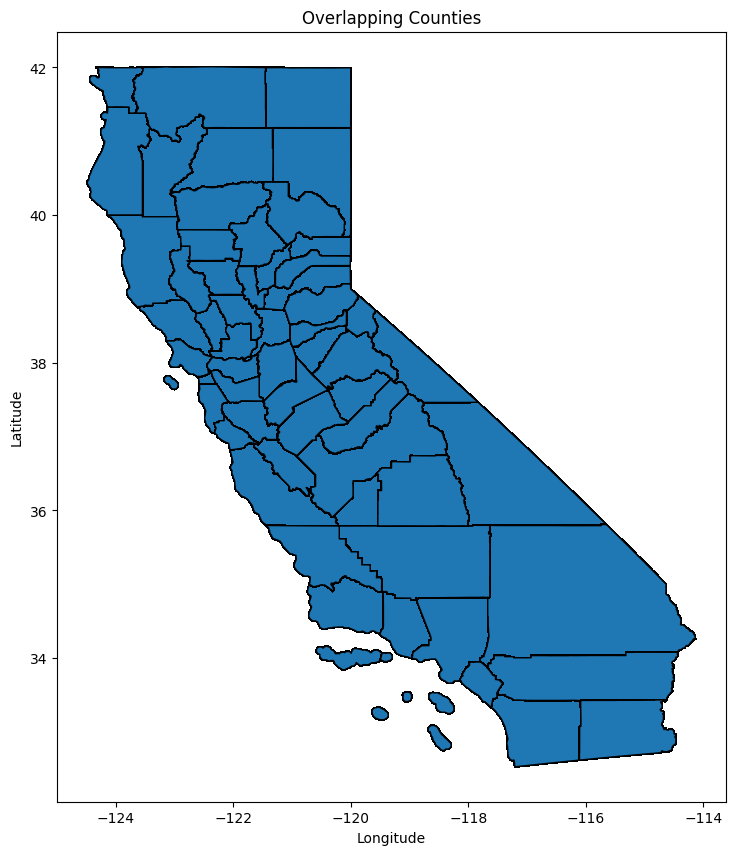

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 将 GeoDataFrame 中的 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)

# 只给 DataFrame 中的 GEOID 列前补充前缀 '0'
df['GEOID'] = '0' + df['GEOID'].astype(str)

# 打印 GeoDataFrame 和 DataFrame 的前几行以查看其结构和内容
print("GeoDataFrame columns:", gdf.columns)
print("DataFrame columns:", df.columns)

# 打印两个数据集中 GEOID 列的前几行以进行检查
print("\nGeoDataFrame GEOID values:")
print(gdf['GEOID'].head())

print("\nDataFrame GEOID values:")
print(df['GEOID'].head())

# 筛选加利福尼亚州的县（STATEFP 为 '06'）
ca_gdf = gdf[gdf['STATEFP'] == '06']

# 打印筛选出的加利福尼亚州县的 GEOID 值
print("\nCalifornia counties GEOID values from GeoDataFrame:")
print(ca_gdf['GEOID'].unique())

# 打印 DataFrame 中的 GEOID 值
print("\nCalifornia counties GEOID values from DataFrame:")
print(df['GEOID'].unique())

# 检查两个数据集的 GEOID 列是否有重叠
common_geoids = set(ca_gdf['GEOID']).intersection(set(df['GEOID']))
print(f"Number of common GEOIDs: {len(common_geoids)}")

# 如果没有重叠的 GEOID，打印不匹配的示例
if len(common_geoids) == 0:
    print("\nNo common GEOIDs found.")
    print("\nExample GEOID values from GeoDataFrame:")
    print(ca_gdf['GEOID'].unique()[:10])
    print("\nExample GEOID values from DataFrame:")
    print(df['GEOID'].unique()[:10])

# 合并数据集，保留共有的县
merged_df = ca_gdf[ca_gdf['GEOID'].isin(common_geoids)].merge(df, on='GEOID')

# 检查合并后的 GeoDataFrame
print("Merged GeoDataFrame:", merged_df.head())

# 确保合并后的 GeoDataFrame 不为空
if not merged_df.empty:
    # 可视化两个数据集重合的县
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    merged_df.plot(ax=ax, edgecolor='black')
    plt.title('Overlapping Counties')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("No overlapping counties found.")

In [17]:
import geopandas as gpd
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 将 GeoDataFrame 中的 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)

# 只给 DataFrame 中的 GEOID 列前补充前缀 '0'
df['GEOID'] = '0' + df['GEOID'].astype(str)

# 合并数据集
merged_df = gdf.merge(df, left_on='GEOID', right_on='GEOID')

# 将合并后的 DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(merged_df)

# 尝试加载 INLA 和 spdep 库，捕获任何错误
try:
    ro.r('library(INLA)')
    ro.r('library(spdep)')
except RRuntimeError as e:
    print(f"Failed to load INLA or spdep library in R: {e}")

def run_inla_spatial_model(formula, data, spatial_data, model_name):
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        ro.r.assign("spatial_data", spatial_data)
        try:
            # 生成空间权重矩阵
            ro.r('nb <- poly2nb(spatial_data$geometry)')
            ro.r('lw <- nb2listw(nb, style="W")')

            # 运行 INLA 模型并直接打印结果
            result = ro.r(f"""
                result <- inla(formula = {formula}, data = r_df, family = 'gaussian',
                               control.compute = list(config = TRUE),
                               control.predictor = list(A = inla.spde.make.A(lw)))
                summary(result)
            """)
            print(f"Model: {model_name} completed successfully.")
            return result
        except RRuntimeError as e:
            print(f"Error running INLA spatial model for {model_name}: {e}")
            return None

def run_all_models(models, data, spatial_data):
    results = {}
    for name, formula in models.items():
        print(f"Running {name}")
        result = run_inla_spatial_model(formula, data, spatial_data, name)
        if result:
            results[name] = result
    return results

# 更新模型公式以包含空间效应
spatial_model_formula = """
SentimentScore ~ as.factor(CountyName) + as.factor(Year) + as.factor(Month) +
                  Week + Weekend + Holiday + VulnerabilityIndex +
                  f(spatial_effect, model = "besag", graph = lw)
"""

# 定义包含空间效应的模型
models = {
    "Spatial Model + Heatwave": spatial_model_formula + " + HeatCount",
    "Spatial Model + Air Pollution": spatial_model_formula + " + AirPolllution_Interpolate",
    "Spatial Model + Precipitation": spatial_model_formula + " + Precipitation",
    "Spatial Model + All Environmental Factors": spatial_model_formula + " + HeatCount + AirPolllution_Interpolate + Precipitation"
}

# 运行所有包含空间效应的模型
model_results = run_all_models(models, r_df, gdf)

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ALAND". Fall back to string conversion. The error is: integer 2468694582 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "AWATER". Fall back to string conversion. The error is: integer 2729213507 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "geometry". Fall back to string conversion. The error is: 'GeometryDtype' object has no attribute 'isnative'
  warnings.warn('Error while trying to convert '


Running Spatial Model + Heatwave


/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "ALAND". Fall back to string conversion. The error is: integer 6016818946 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '
/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "AWATER". Fall back to string conversion. The error is: integer 2908633230 does not fit '32-bit int'
  warnings.warn('Error while trying to convert '



Error running INLA spatial model for Spatial Model + Heatwave: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + Air Pollution


Error running INLA spatial model for Spatial Model + Air Pollution: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + Precipitation


Error running INLA spatial model for Spatial Model + Precipitation: Error in poly2nb(spatial_data$geometry) : Not a polygon object

Running Spatial Model + All Environmental Factors


Error running INLA spatial model for Spatial Model + All Environmental Factors: Error in poly2nb(spatial_data$geometry) : Not a polygon object



还是geodataframe转换为r时候出现了数据类型不兼容的问题

In [ ]:
import geopandas as gpd
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError

# 激活Pandas DataFrame到R data.frame的自动转换
pandas2ri.activate()

# 加载 Shapefile
shapefile_path = "/content/County.shp"
gdf = gpd.read_file(shapefile_path)

# 加载原始数据
data_path = "/content/TestData_California.csv"
df = pd.read_csv(data_path)

# 将 GeoDataFrame 中的 'GEOID' 列转换为字符串类型
gdf['GEOID'] = gdf['GEOID'].astype(str)

# 只给 DataFrame 中的 GEOID 列前补充前缀 '0'
df['GEOID'] = '0' + df['GEOID'].astype(str)

# 合并数据集
merged_df = gdf.merge(df, left_on='GEOID', right_on='GEOID')

# 删除 'ALAND' 和 'AWATER' 列，并将 'geometry' 列转换为 WKT 格式
merged_df = merged_df.drop(columns=['ALAND', 'AWATER'])
merged_df['geometry'] = merged_df['geometry'].apply(lambda x: x.wkt)

# 将合并后的 DataFrame 转换为 R 的 data.frame
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = pandas2ri.py2rpy(merged_df)

# 尝试加载 INLA 和 spdep 库，捕获任何错误
try:
    ro.r('library(INLA)')
    ro.r('library(spdep)')
except RRuntimeError as e:
    print(f"Failed to load INLA or spdep library in R: {e}")

def run_inla_spatial_model(formula, data, spatial_data, model_name):
    with localconverter(ro.default_converter + pandas2ri.converter):
        ro.r.assign("r_df", data)
        ro.r.assign("spatial_data", spatial_data)
        try:
            # 生成空间权重矩阵
            ro.r('nb <- poly2nb(as(spatial_data, "Spatial"))')
            ro.r('lw <- nb2listw(nb, style="W")')

            # 运行 INLA 模型并直接打印结果
            result = ro.r(f"""
                result <- inla(formula = {formula}, data = r_df, family = 'gaussian',
                               control.compute = list(config = TRUE),
                               control.predictor = list(A = inla.spde.make.A(lw)))
                summary(result)
            """)
            print(f"Model: {model_name} completed successfully.")
            return result
        except RRuntimeError as e:
            print(f"Error running INLA spatial model for {model_name}: {e}")
            return None

def run_all_models(models, data, spatial_data):
    results = {}
    for name, formula in models.items():
        print(f"Running {name}")
        result = run_inla_spatial_model(formula, data, spatial_data, name)
        if result:
            results[name] = result
    return results

# 更新模型公式以包含空间效应
spatial_model_formula = """
SentimentScore ~ as.factor(CountyName) + as.factor(Year) + as.factor(Month) +
                  Week + Weekend + Holiday + VulnerabilityIndex +
                  f(spatial_effect, model = "besag", graph = lw)
"""

# 定义包含空间效应的模型
models = {
    "Spatial Model + Heatwave": spatial_model_formula + " + HeatCount",
    "Spatial Model + Air Pollution": spatial_model_formula + " + AirPolllution_Interpolate",
    "Spatial Model + Precipitation": spatial_model_formula + " + Precipitation",
    "Spatial Model + All Environmental Factors": spatial_model_formula + " + HeatCount + AirPolllution_Interpolate + Precipitation"
}

# 运行所有包含空间效应的模型
model_results = run_all_models(models, r_df, gdf)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation


package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`





Running Spatial Model + Heatwave


colab环境可以使用r语言


In [ ]:
install.packages(c("INLA", "spdep", "sf", "data.table"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘INLA’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
